## Посимвольная языковая модель. Часть 2.

В этом задании Вам нужно использовать написанную языковую модель для генерации воображаемых какслов.

**В процессе написания Вам нужно решить следующие проблемы**:
    
* как запоминать изменившееся состояние модели и передавать его на следующий временной шаг.
* что будет начальным состоянием модели.
* как понять, что слово закончилось и нужно прекратить генерацию.

**Результаты**:

* генератор слов на основе обученной посимвольной модели
* посимвольные вероятности сгенерированных слов

**Дополнительно**:

* ускорение модели за счёт побатчевой генерации

In [0]:
# it is better to do all imports at the first cell
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as func
from torch.autograd import Variable
import random
import matplotlib.pyplot as plt
import torch.utils.data as utils
import time
import math

In [176]:
USE_GPU = True

dtype = torch.float32

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print('using device:', device)

using device: cuda


In [177]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
!wget https://raw.githubusercontent.com/sigmorphon/conll2018/master/task1/surprise/russian-train-high
!wget https://raw.githubusercontent.com/sigmorphon/conll2018/master/task1/surprise/russian-dev
!wget https://raw.githubusercontent.com/sigmorphon/conll2018/master/task1/surprise/russian-test

Для каждого слова будем применять посимвольную генерацию, на каждом шаге входные данные: current letter + hidden state
Затем с помощью crossentropyloss считаем loss

На тесте будем передавать начальную букву, вероятности считаем софтмаксом

In [0]:
def read_dataset(infile):
    words, tags = [], []
    with open(infile, "r", encoding="utf8") as f:
        for line in f:
            line = line.strip()
            splitted = line.split("\t")
            if len(splitted) != 3:
                continue
            words.append(splitted[0].lower())
            tags.append(splitted[2])
    return words, tags

train_words, train_tags = read_dataset("russian-train-high")
dev_words, dev_tags = read_dataset("russian-dev")
test_words, test_tags = read_dataset("russian-test")

## Vocabulary  + batcher

In [0]:
AUXILIARY = {'<END>'}

In [0]:
class Vocabulary:
    def fit(self, data):
        """Extract unique symbols from the data, make itos (item to string) and stoi (string to index) objects"""
        symbols = set(x for elem in data for x in elem)
        self._symbols = AUXILIARY.copy()
        self._symbols.update(symbols)
        self._symbols = sorted(self._symbols)
        # Запомните следующую строчку кода - она нужна примерно всегда
        self._symbol_codes = {s: i for i, s in enumerate(self._symbols)}# символ - индекс
        self._codes_symbol = {v: k for k, v in self._symbol_codes.items()}
        # 
        self.corpus = self.transform(data)
        self.longest = max(len(i) for i in self.corpus)
        self.paddings = [i + [self._symbol_codes['<END>']]*(self.longest - len(i)+1) for i in self.corpus]
        self.longest = max(len(i) for i in self.paddings)
        return self

    def __len__(self):
        return len(self._symbols)

    def transform(self, data):
        """Transform data to indices
        Input:
            - data, list of strings
        Output:
            - list of list of char indices
        >>> self.transform(['word1', 'token2'])
        >>> [[24, 2, 19, 13, 3], [8, 2, 9, 1, 7, 4]]
        """
        for i in data:
            for j in i:
                if j not in self._symbols:
                    print("UNKNOWN SYMBOL: {}".format(j))
                    return None
        return [[self._symbol_codes[str(j)] for j in i] for i in data]
    def str_by_ind(self, v):# get words from indexes
        s = [self._codes_symbol[i.item()] for i in v]
        s = ''.join(i for i in s)
        print(s)

In [0]:
class Batch:
    def __init__(self, vocab):
        self.sym_ind = vocab._symbol_codes
        self.paddings = vocab.paddings
        self.longest = vocab.longest
    def make_batch(self, batch_size):
        sample = torch.LongTensor(batch_size, self.longest-1)
        pred = torch.LongTensor(batch_size, self.longest-1)
        for i in range(batch_size):
            index = random.randint(0, len(self.paddings)-1)
            s = torch.Tensor(self.paddings[index])
            sample[i] = (s[:-1])
            pred[i] = (s[1:])
        sample = sample.cuda()
        pred = pred.cuda()
        return sample, pred

## Модель

In [0]:
class Net(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, n_layers=1):
        super(Net, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = input_size
        self.n_layers = n_layers
        
        self.encoder = nn.Embedding(self.input_size, self.hidden_size)
        self.lstm = nn.LSTM(self.hidden_size, self.hidden_size, self.n_layers)
        self.decoder = nn.Linear(self.hidden_size, self.output_size)
        self.softmax = nn.LogSoftmax(dim= -1)
        
    def forward(self, x, hidden):
        batch_size = x.size(0)
        x = self.encoder(x)
        out, hidden = self.lstm(x.view(1, batch_size, -1), hidden)
        out = self.decoder(out.view(batch_size, -1))
        out = self.softmax(out)
        return out, hidden
      
    def init_hidden(self, batch_size):
        return torch.zeros(self.n_layers, batch_size, self.hidden_size, device = device), torch.zeros(self.n_layers, batch_size, self.hidden_size, device = device)

## Parameters

In [0]:
a = Vocabulary()
a.fit(train_words)# make corpus + dict symbol-code
b = Batch(a)#make batches on corpus

In [0]:
batch_size = 128
lr = 0.01
input_size = len(a)
hidden_size = 100
n_layers = 3
n_epochs = 3000
print_every = 100

In [0]:
model = Net(input_size, hidden_size, input_size, n_layers).to(device=device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = nn.NLLLoss()
loss = torch.tensor(0)

## Train

In [0]:
def timeSince(since):
    now = time.clock()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [0]:
def train(inp, target):
    model.zero_grad()
    loss = 0
    
    hidden = model.init_hidden(batch_size)
    
    model.train()
    for i in range(a.longest-1):
        output, hidden = model(inp[:,i],hidden)
        loss += criterion(output.view(batch_size,-1), target[:,i])
        
    loss.backward()
    optimizer.step()
    
    return output, loss.item()/a.longest

In [230]:
start_time = time.clock()
losses = []
perplexity = []
for epoch in range(1, n_epochs + 1):
    out, loss = train(*b.make_batch(batch_size))
    losses.append(loss)
    perplexity.append(np.exp(losses[-1]))
    if epoch % print_every == 0:
        print('epoch {},   \tloss {} \tperplexity {}'.format(epoch, losses[-1], perplexity[-1]))
        print('time passed %s:' %(timeSince(start_time)))

epoch 100,   	loss 0.47248580239035864 	perplexity 1.6039764100589113
time passed 0m 9s:
epoch 200,   	loss 0.42840016971934924 	perplexity 1.534800138636478
time passed 0m 18s:
epoch 300,   	loss 0.3975770256736062 	perplexity 1.488214420270365
time passed 0m 27s:
epoch 400,   	loss 0.3902617367831143 	perplexity 1.4773674246798985
time passed 0m 36s:
epoch 500,   	loss 0.3594828085465865 	perplexity 1.4325883005026516
time passed 0m 45s:
epoch 600,   	loss 0.34950134970925073 	perplexity 1.4183601065453086
time passed 0m 54s:
epoch 700,   	loss 0.34428843584927643 	perplexity 1.4109855556367377
time passed 1m 3s:
epoch 800,   	loss 0.32368705489418725 	perplexity 1.382214682109122
time passed 1m 12s:
epoch 900,   	loss 0.3169273679906672 	perplexity 1.372902851611328
time passed 1m 21s:
epoch 1000,   	loss 0.30714351480657404 	perplexity 1.3595360676275843
time passed 1m 30s:
epoch 1100,   	loss 0.29177379608154297 	perplexity 1.338800141546657
time passed 1m 39s:
epoch 1200,   	loss

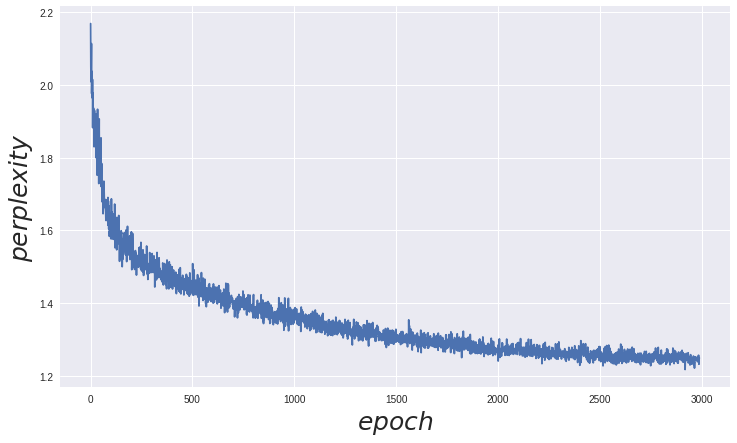

In [232]:
plt.figure(figsize=(12,7))
plt.plot(range(len(perplexity[10:])), perplexity[10:])
plt.xlabel("$epoch$", fontsize=25)
plt.ylabel("$perplexity$", fontsize=25)
plt.show()

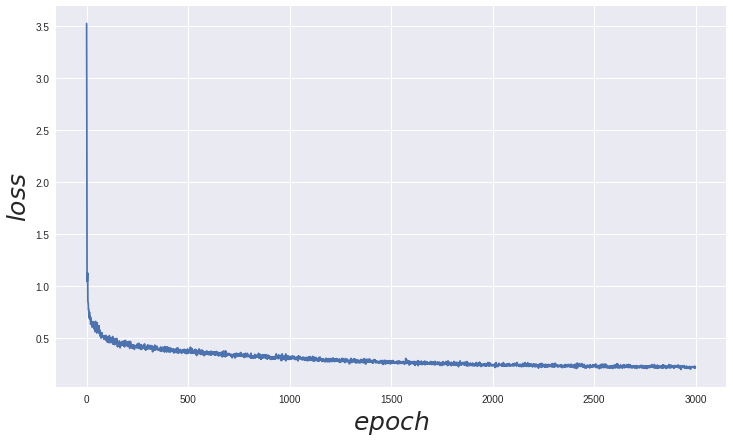

In [233]:
plt.figure(figsize=(12,7))
plt.plot(range(len(losses)), losses)
plt.xlabel("$epoch$", fontsize=25)
plt.ylabel("$loss$", fontsize=25)
plt.show()

## Sampling the Network

In [0]:
def generate(batch_size, index):
    hidden = model.init_hidden(batch_size)
    symbol = torch.tensor([index]).cuda()
    pred = [a._codes_symbol[index]]
    with torch.no_grad():
        for i in range(a.longest-1):
            output, hidden = model(symbol,hidden)
            _, index = torch.max(func.softmax(output, dim = 1),1)
            if index.item() == 2:# end 
              pr = "".join(str(e) for e in pred)
              return pr
            pred.append(a._codes_symbol[index.item()])
            symbol = torch.tensor([index]).cuda()
    pr = "".join(str(e) for e in pred)
    
    return pr

In [398]:
for i in range(3, 36):
  out = generate(1, i)
  print('{}:\t {}'.format(a._codes_symbol[i], out))

а:	 абсолютный
б:	 безотказный
в:	 высокомерие
г:	 грузовой
д:	 долговой
е:	 единоутробный
ж:	 желательный
з:	 заморозить
и:	 извещение
й:	 йоркширский
к:	 конспект
л:	 лесопиловательный
м:	 малайция
н:	 непростывать
о:	 оборонник
п:	 подстроить
р:	 разрастись
с:	 соверчий
т:	 транспортировка
у:	 усилиться
ф:	 фальчион
х:	 христадель
ц:	 целенапримод
ч:	 чередовать
ш:	 штатировать
щ:	 щуп
ъ:	 ъесть
ы:	 ыбить
ь:	 ь
э:	 экстрадировать
ю:	 юнильняться
я:	 языковой боловка
ё:	 ёбнутый
